In [ ]:
# =========================
# Unified Multi-Domain Meta-Training - FIXED for EuroSAT validation
# Features: Attention, Early Stopping, Cross-Dataset Testing, Adaptive Sampling
# Fixes applied: EuroSAT safe split (6/2/2), BASE_QUERY=12, always sample-with-replacement for small classes
# =========================

# Step 1: Mount Google Drive (run in Colab)
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Install required packages
import subprocess
import sys

def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])

try:
    import torchvision
except Exception:
    print("Installing torchvision...")
    install_package("torchvision")

try:
    import tifffile
except Exception:
    print("Installing tifffile...")
    install_package("tifffile")

# Step 3: Import all libraries
import os
import random
import time
import zipfile
import shutil
import csv
import warnings
from pathlib import Path
from collections import defaultdict
import math
import glob

import numpy as np
from PIL import Image, ImageFile
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
from torchvision import transforms
from torch.utils.data import Dataset
import tifffile

# Robust allowlist for torch.load / safe unpickle (best-effort)
try:
    import torch.serialization
    _safe_list = []
    try:
        _safe_list = [np.dtype, np.ndarray]
    except Exception:
        _safe_list = []
    for s in _safe_list:
        try:
            torch.serialization.add_safe_globals([s])
        except Exception:
            pass
except Exception:
    pass

def robust_torch_load(path, map_location=None):
    try:
        return torch.load(path, map_location=map_location)
    except Exception as e:
        msg = str(e).lower()
        if ('weights only' in msg) or ('unsupported global' in msg) or ('safe_globals' in msg) or ('numpy' in msg):
            print("Warning: torch.load raised safe-globals / weights_only error. Trying fallback inside safe_globals() context...")
            allow = []
            try:
                allow = [np.core.multiarray.scalar, np.dtype, np.int64, np.float64, np.ndarray]
            except Exception:
                allow = []
            try:
                with torch.serialization.safe_globals(allow):
                    return torch.load(path, map_location=map_location, weights_only=False)
            except Exception as e2:
                print(f"Fallback load inside safe_globals failed: {e2}")
                raise
        raise

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"
warnings.filterwarnings("ignore")
ImageFile.LOAD_TRUNCATED_IMAGES = True

print("="*70)
print("✓ All packages imported successfully!")
print("="*70)

# ============================================================================
#                              CONFIGURATION
# ============================================================================

BASE_DATA_PATH = "/content/drive/MyDrive/datasets"
RESULTS_ROOT = "/content/drive/MyDrive/MetaLearning_OptimizedV2_Results"
os.makedirs(RESULTS_ROOT, exist_ok=True)

DATASETS = {
    "EuroSAT": {
        "zip_names": ["EuroSAT.zip", "EURO.zip", "EuroSAT_RGB.zip"],
        "folder": "EuroSAT",
        "img_size": 128  # Closer to native 64x64
    },
    "AID": {
        "zip_names": ["AID.zip", "AID_dataset.zip"],
        "folder": "AID",
        "img_size": 256  # Better for 600x600
    },
    "NWPU": {
        "zip_names": ["NPWU.zip", "NWPU.zip", "NWPU-RESISC45.zip", "NWPU_RESISC45.zip"],
        "folder": "RESISC45",
        "img_size": 224  # Good for 256x256
    }
}

# Meta-learning hyperparams - OPTIMIZED
WAY = 5
SHOT_LIST = [1, 2, 3, 4, 5]
BASE_QUERY = 12  # <-- changed per your instruction
TOTAL_EPISODES = 17500
VALIDATE_EVERY = 2500
TEST_EPISODES = 1000
VALIDATION_EPISODES = 500

LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
RELATION_DIM = 256
SEED = 42

EARLY_STOP_PATIENCE = 3
EARLY_STOP_MIN_DELTA = 0.001

CURRICULUM_SCHEDULE = {
    0: 5,
    7500: 3,
    12500: 1
}

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
scaler = GradScaler(enabled=use_cuda)

print(f"\n{'='*70}")
print(f"Configuration Loaded:")
print(f"  Device: {device}")
print(f"  Total Episodes: {TOTAL_EPISODES}")
print(f"  Early Stopping: Patience={EARLY_STOP_PATIENCE}, Min Delta={EARLY_STOP_MIN_DELTA}")
print(f"  Attention-based Relation Network: Enabled")
print(f"  Cross-Dataset Testing: Enabled")
print(f"{'='*70}\n")

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed_all(SEED)

# ============================================================================
#                           DATASET EXTRACTION
# ============================================================================

def extract_zip_if_needed(dataset_key):
    """Extract dataset zip and return data root path"""
    info = DATASETS[dataset_key]
    extract_base = Path(f"/content/{dataset_key}")
    extract_base.mkdir(parents=True, exist_ok=True)

    def is_valid_data_root(path):
        try:
            subs = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
            if len(subs) < 2:
                return False
            for s in subs[:10]:
                sd = os.path.join(path, s)
                imgs = [f for f in os.listdir(sd) if f.lower().endswith(('.jpg','.jpeg','.png','.tif','.tiff'))]
                if len(imgs) > 0:
                    return True
            return False
        except:
            return False

    # Check if already extracted
    if extract_base.exists() and any(extract_base.iterdir()):
        if is_valid_data_root(str(extract_base)):
            return str(extract_base)
        for entry in extract_base.iterdir():
            if entry.is_dir() and is_valid_data_root(str(entry)):
                return str(entry)

    # Find and extract zip
    found = None
    for name in info["zip_names"]:
        p = Path(BASE_DATA_PATH) / name
        if p.exists():
            found = str(p)
            print(f"[{dataset_key}] Found zip: {name}")
            break

    if found is None:
        for fname in os.listdir(BASE_DATA_PATH):
            if dataset_key.lower() in fname.lower() and fname.lower().endswith(".zip"):
                found = str(Path(BASE_DATA_PATH) / fname)
                print(f"[{dataset_key}] Found fallback zip: {fname}")
                break

    if found is None:
        raise FileNotFoundError(f"Could not find dataset zip for {dataset_key}")

    print(f"[{dataset_key}] Extracting {Path(found).name} -> {extract_base}")
    tmpzip = "/content/tmp_ds.zip"
    shutil.copy(found, tmpzip)
    with zipfile.ZipFile(tmpzip, 'r') as z:
        z.extractall(str(extract_base))
    os.remove(tmpzip)
    print(f"[{dataset_key}] Extraction complete!")

    # Find data root
    candidates = []
    for root, dirs, files in os.walk(str(extract_base)):
        if any(part.startswith('.') for part in Path(root).parts):
            continue
        subdirs = [d for d in dirs if not d.startswith('.')]
        if len(subdirs) >= 2:
            for d in subdirs[:10]:
                try:
                    imgs = [f for f in os.listdir(os.path.join(root, d))
                           if f.lower().endswith(('.jpg','.jpeg','.png','.tif','.tiff'))]
                    if len(imgs) > 0:
                        candidates.append(root)
                        break
                except:
                    continue

    if candidates:
        chosen = sorted(candidates, key=lambda p: len(Path(p).parts))[0]
        print(f"[{dataset_key}] Detected data root: {chosen}")
        return chosen

    print(f"[{dataset_key}] Warning: Using top-level folder")
    return str(extract_base)

# ============================================================================
#                           DATASET CLASS
# ============================================================================

class RemoteSensingDataset(Dataset):
    """Remote sensing dataset with adaptive sampling support"""
    def __init__(self, root_dir, transform=None, dataset_name="Unknown"):
        self.root_dir = root_dir
        self.transform = transform
        self.dataset_name = dataset_name

        def find_data_root(path):
            try:
                for entry in os.listdir(path):
                    p = os.path.join(path, entry)
                    if os.path.isdir(p):
                        subs = [d for d in os.listdir(p) if os.path.isdir(os.path.join(p, d))]
                        if len(subs) >= 2:
                            for s in subs[:10]:
                                imgs = [f for f in os.listdir(os.path.join(p, s))
                                       if f.lower().endswith(('.jpg','.jpeg','.png','.tif','.tiff'))]
                                if len(imgs) > 0:
                                    return p
            except:
                pass
            return path

        candidate_root = find_data_root(self.root_dir)
        self.root_dir = candidate_root

        self.classes = sorted([d for d in os.listdir(self.root_dir)
                             if os.path.isdir(os.path.join(self.root_dir, d))])
        if len(self.classes) == 0:
            raise FileNotFoundError(f"No class folders in {self.root_dir}")

        print(f"    [{dataset_name}] Classes found: {len(self.classes)}")

        # Build class-to-images mapping
        self.data_by_class = {}
        for idx, cls in enumerate(self.classes):
            folder = os.path.join(self.root_dir, cls)
            try:
                imgs = [os.path.join(folder, f) for f in os.listdir(folder)
                        if f.lower().endswith(('.jpg','.jpeg','.png','.tif','.tiff'))]
            except:
                imgs = []
            imgs = [p for p in imgs if os.path.exists(p)]
            if len(imgs) > 0:
                self.data_by_class[idx] = imgs

    def load_image(self, path):
        """Smart image loader for multi-spectral and RGB images"""
        img = None

        # Handle TIFFs (EuroSAT)
        if path.lower().endswith(('.tif', '.tiff')):
            try:
                arr = tifffile.imread(path)
                if arr is None:
                    raise ValueError("tifffile returned None")

                # Standardize to (H, W, C)
                if arr.ndim == 3 and arr.shape[0] < arr.shape[1]:
                    arr = np.moveaxis(arr, 0, -1)

                # Band selection for RGB
                if arr.ndim == 3:
                    if arr.shape[2] >= 4:
                        # B4(Red), B3(Green), B2(Blue)
                        idxs = [3, 2, 1] if arr.shape[2] > 3 else list(range(arr.shape[2]))
                        arr = arr[:, :, idxs]
                    elif arr.shape[2] == 3:
                        pass
                    else:
                        arr = np.repeat(arr[:, :, :1], 3, axis=2)
                elif arr.ndim == 2:
                    arr = np.repeat(arr[:, :, np.newaxis], 3, axis=2)

                # Normalize (percentile-based for robustness)
                p99 = np.percentile(arr, 99) if arr.size > 0 else 255
                arr = np.clip(arr, 0, p99)
                arr = (arr / (p99 + 1e-9) * 255.0).astype(np.uint8)

                img = Image.fromarray(arr)
            except Exception as e:
                img = None

        # Standard PIL loading
        if img is None:
            try:
                img = Image.open(path)
                if img.mode != "RGB":
                    img = img.convert("RGB")
            except:
                img = Image.new("RGB", (224, 224), (0, 0, 0))

        if self.transform:
            img = self.transform(img)

        return img

# ============================================================================
#                    ADAPTIVE EPISODE SAMPLING (WITH REPLACEMENT)
# ============================================================================

def sample_episode_adaptive(dataset_obj, n_way, k_shot, n_query):
    """
    Adaptive episode sampling that handles small classes gracefully.
    For your preference: keep n_query fixed (BASE_QUERY) and sample-with-replacement
    whenever a class has fewer than k_shot + n_query images.
    """
    classes = list(dataset_obj.data_by_class.keys())
    if len(classes) < n_way:
        raise ValueError(f"Not enough classes: need {n_way}, have {len(classes)}")

    selected = random.sample(classes, n_way)
    support_imgs, support_labels = [], []
    query_imgs, query_labels = [], []

    for i, cls in enumerate(selected):
        paths = dataset_obj.data_by_class[cls]
        need = k_shot + n_query

        if len(paths) >= need:
            chosen = random.sample(paths, need)
        else:
            # sample with replacement for uniform episodes
            chosen = [random.choice(paths) for _ in range(need)]

        s_paths = chosen[:k_shot]
        q_paths = chosen[k_shot:k_shot + n_query]

        for p in s_paths:
            support_imgs.append(dataset_obj.load_image(p))
            support_labels.append(i)
        for p in q_paths:
            query_imgs.append(dataset_obj.load_image(p))
            query_labels.append(i)

    support_imgs = torch.stack(support_imgs)
    query_imgs = torch.stack(query_imgs)
    support_labels = torch.tensor(support_labels, dtype=torch.long)
    query_labels = torch.tensor(query_labels, dtype=torch.long)

    return support_imgs, support_labels, query_imgs, query_labels


def sample_episode_balanced_rotation(datasets_dict, dataset_keys, episode_idx, n_way, k_shot, n_query):
    """
    Episode-based balanced sampling: rotate through datasets evenly.
    """
    chosen_key = dataset_keys[episode_idx % len(dataset_keys)]
    ds = datasets_dict[chosen_key]['train']

    s_imgs, s_lbls, q_imgs, q_lbls = sample_episode_adaptive(ds, n_way, k_shot, n_query)
    return s_imgs, s_lbls, q_imgs, q_lbls, chosen_key

# ============================================================================
#                      ATTENTION-BASED MODELS
# ============================================================================

print("Loading EfficientNet-B0 (pretrained on ImageNet)...")
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
base_model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
print("✓ Model loaded successfully!\n")

class EfficientNetEncoder(nn.Module):
    """EfficientNet-B0 feature encoder"""
    def __init__(self, out_channels=128):
        super().__init__()
        self.backbone = base_model.features
        self.reduce = nn.Sequential(
            nn.Conv2d(1280, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        f = self.backbone(x)
        f = self.reduce(f)
        return f

class AttentionModule(nn.Module):
    """Self-attention for relation features with scaling + optional downsample"""
    def __init__(self, in_channels):
        super().__init__()
        self.query = nn.Conv2d(in_channels, max(1, in_channels // 8), kernel_size=1)
        self.key = nn.Conv2d(in_channels, max(1, in_channels // 8), kernel_size=1)
        self.value = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        B, C, H, W = x.size()

        # Optional downsampling if spatial size is large to save memory
        downsampled = False
        x_ds = x
        if (H * W) > 196:  # threshold (e.g., >14x14)
            x_ds = F.avg_pool2d(x, kernel_size=2)
            downsampled = True

        B_ds, C_ds, H_ds, W_ds = x_ds.size()

        proj_query = self.query(x_ds).view(B_ds, -1, H_ds * W_ds).permute(0, 2, 1)
        proj_key = self.key(x_ds).view(B_ds, -1, H_ds * W_ds)

        d_k = proj_query.size(-1)
        energy = torch.bmm(proj_query, proj_key) / math.sqrt(max(1.0, d_k))
        attention = F.softmax(energy, dim=-1)

        proj_value = self.value(x_ds).view(B_ds, -1, H_ds * W_ds)
        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(B_ds, C_ds, H_ds, W_ds)

        if downsampled:
            out = F.interpolate(out, size=(H, W), mode='bilinear', align_corners=False)

        out = self.gamma * out + x
        return out

class AttentionRelationNetwork(nn.Module):
    """Enhanced Relation Network with Attention"""
    def __init__(self, in_channels, hidden_size=RELATION_DIM):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            AttentionModule(256),
            nn.MaxPool2d(2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            AttentionModule(128),
            nn.MaxPool2d(2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.fc1 = nn.Linear(64, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x.view(-1)

# ============================================================================
#                         DATA TRANSFORMS
# ============================================================================

def get_transforms(img_size):
    """Get dataset-specific transforms"""
    train_transform = transforms.Compose([
        transforms.Resize((img_size + 32, img_size + 32)),
        transforms.RandomCrop((img_size, img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(45),
        transforms.ColorJitter(0.3, 0.3, 0.3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    test_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    return train_transform, test_transform

# ============================================================================
#                         FAST EVALUATION (Feature precompute)
# ============================================================================

@torch.no_grad()
def precompute_features_for_dataset(encoder, dataset_obj, batch_size=64):
    """
    Precompute encoder features for every image in dataset_obj (val/test splits).
    Returns: dict[class_id] -> list of CPU tensors (features: [C,H,W])
    """
    encoder.eval()
    device_local = next(encoder.parameters()).device

    entries = []  # list of (class, path)
    for cls, paths in dataset_obj.data_by_class.items():
        for p in paths:
            entries.append((cls, p))
    if len(entries) == 0:
        return {}

    imgs = []
    classes = []
    features_by_class = defaultdict(list)

    for idx, (cls, p) in enumerate(entries):
        img = dataset_obj.load_image(p)
        imgs.append(img)
        classes.append(cls)
        if len(imgs) == batch_size or idx == len(entries) - 1:
            batch = torch.stack(imgs).to(device_local)
            feat = encoder(batch)  # [B, C, H, W]
            feat = feat.detach().cpu()
            for i in range(feat.size(0)):
                # store a clone to avoid accidental aliasing issues
                features_by_class[classes[i]].append(feat[i].clone())
            imgs = []
            classes = []

    # remove empty classes
    features_by_class = {k: v for k, v in features_by_class.items() if len(v) > 0}
    return features_by_class

@torch.no_grad()
def evaluate_on_dataset_fast(encoder, relation, dataset_obj, n_way, k_shot, n_query, episodes=VALIDATION_EPISODES, device_eval=None, batch_size=64):
    """
    Fast evaluator using precomputed features (caches features for the dataset on call).
    Keeping n_query fixed (sample with replacement for small classes).
    """
    if device_eval is None:
        device_eval = device

    feature_cache = precompute_features_for_dataset(encoder, dataset_obj, batch_size=batch_size)
    if len(feature_cache) == 0:
        # Avoid returning 0.0 blindly; this indicates no images in dataset split
        return 0.0

    classes = list(feature_cache.keys())
    if len(classes) < n_way:
        # If not enough distinct classes in this split, we can still sample but must allow replacement of classes.
        # Here we allow sampling with replacement across available classes.
        pass

    encoder.eval()
    relation.eval()

    total_correct = 0
    total_count = 0

    for _ in range(episodes):
        # If fewer classes than n_way, sample classes with replacement
        if len(classes) >= n_way:
            selected = random.sample(classes, n_way)
        else:
            selected = [random.choice(classes) for _ in range(n_way)]

        support_feats = []
        query_feats = []
        support_labels = []
        query_labels = []

        for i, cls in enumerate(selected):
            feats_list = feature_cache[cls]
            need = k_shot + n_query
            if len(feats_list) >= need:
                chosen = random.sample(feats_list, need)
            else:
                # sample with replacement -- duplicate features will be clones of tensors
                chosen = [random.choice(feats_list).clone() for _ in range(need)]

            s_feats = chosen[:k_shot]
            q_feats = chosen[k_shot:k_shot + n_query]
            for p in s_feats:
                support_feats.append(p)
                support_labels.append(i)
            for p in q_feats:
                query_feats.append(p)
                query_labels.append(i)

        # Stack and move to device
        s_feat = torch.stack(support_feats).to(device_eval)
        q_feat = torch.stack(query_feats).to(device_eval)
        s_lbl = torch.tensor(support_labels, dtype=torch.long, device=device_eval)
        q_lbl = torch.tensor(query_labels, dtype=torch.long, device=device_eval)

        n_s = s_feat.size(0)
        n_q = q_feat.size(0)
        s_ext = s_feat.unsqueeze(0).repeat(n_q, 1, 1, 1, 1)
        q_ext = q_feat.unsqueeze(1).repeat(1, n_s, 1, 1, 1)
        pairs = torch.cat((s_ext, q_ext), dim=2)
        pairs = pairs.view(-1, pairs.size(2), pairs.size(3), pairs.size(4))

        relations = relation(pairs)
        relations = relations.view(n_q, n_s)

        scores = torch.zeros(n_q, n_way, device=device_eval)
        for j in range(n_s):
            cls = s_lbl[j].long()
            scores[:, cls] += relations[:, j]

        preds = torch.argmax(scores, dim=1)
        total_correct += (preds == q_lbl).sum().item()
        total_count += n_q

    return total_correct / total_count if total_count > 0 else 0.0

# ============================================================================
#                         EVALUATION FUNCTIONS (legacy)
# ============================================================================
@torch.no_grad()
def evaluate_on_dataset(encoder, relation, dataset_obj, n_way, k_shot, n_query, episodes=TEST_EPISODES, use_precompute=True):
    """Evaluate model on test episodes. use_precompute=True will precompute features once for accurate final eval."""
    encoder.eval()
    relation.eval()
    total_correct = 0
    total_count = 0

    features_by_class = None
    if use_precompute:
        features_by_class = precompute_features_for_dataset(encoder, dataset_obj)
        if len(features_by_class) == 0:
            use_precompute = False

    for _ in range(episodes):
        try:
            if use_precompute:
                # sample from precomputed
                classes = list(features_by_class.keys())
                if len(classes) >= n_way:
                    selected = random.sample(classes, n_way)
                else:
                    selected = [random.choice(classes) for _ in range(n_way)]

                support_feats, support_labels, query_feats, query_labels = [], [], [], []
                for i, cls in enumerate(selected):
                    feats = features_by_class[cls]
                    need = k_shot + n_query
                    if len(feats) >= need:
                        chosen = random.sample(feats, need)
                    else:
                        chosen = [random.choice(feats).clone() for _ in range(need)]

                    s_f = chosen[:k_shot]
                    q_f = chosen[k_shot:k_shot + n_query]
                    for p in s_f:
                        support_feats.append(p)
                        support_labels.append(i)
                    for p in q_f:
                        query_feats.append(p)
                        query_labels.append(i)
                s_feat = torch.stack(support_feats).to(device)
                q_feat = torch.stack(query_feats).to(device)
                s_lbl = torch.tensor(support_labels, dtype=torch.long, device=device)
                q_lbl = torch.tensor(query_labels, dtype=torch.long, device=device)
            else:
                s_img, s_lbl, q_img, q_lbl = sample_episode_adaptive(dataset_obj, n_way, k_shot, n_query)
                s_img, q_img = s_img.to(device), q_img.to(device)
                s_lbl, q_lbl = s_lbl.to(device), q_lbl.to(device)
                s_feat = encoder(s_img)
                q_feat = encoder(q_img)
        except Exception:
            continue

        n_s = s_feat.size(0)
        n_q = q_feat.size(0)
        s_ext = s_feat.unsqueeze(0).repeat(n_q, 1, 1, 1, 1)
        q_ext = q_feat.unsqueeze(1).repeat(1, n_s, 1, 1, 1)
        pairs = torch.cat((s_ext, q_ext), dim=2)
        pairs = pairs.view(-1, pairs.size(2), pairs.size(3), pairs.size(4))

        relations = relation(pairs).view(n_q, n_s)

        scores = torch.zeros(n_q, n_way, device=device)
        for j in range(n_s):
            cls = s_lbl[j].long()
            scores[:, cls] += relations[:, j]

        preds = torch.argmax(scores, dim=1)
        total_correct += (preds == q_lbl).sum().item()
        total_count += n_q

    return total_correct / total_count if total_count > 0 else 0.0

# ============================================================================
#                         MAIN TRAINING FUNCTION
# ============================================================================

def find_most_recent_checkpoint(results_root, target_name="latest.pth"):
    candidates = []
    if not os.path.exists(results_root):
        return None, None
    for entry in os.listdir(results_root):
        sub = os.path.join(results_root, entry)
        if os.path.isdir(sub):
            candidate = os.path.join(sub, target_name)
            if os.path.exists(candidate):
                mtime = os.path.getmtime(candidate)
                candidates.append((mtime, candidate, sub))
    if not candidates:
        return None, None
    candidates = sorted(candidates, key=lambda x: x[0], reverse=True)
    return candidates[0][1], candidates[0][2]

def cross_dataset_evaluation(encoder, relation, dataset_objs, dataset_keys, target_keys, shot_list):
    """
    Very simple cross-dataset evaluation helper:
    Train episodes were mixed; for cross dataset we evaluate the trained encoder+relation on
    target dataset(s) with k-shot protocol.
    """
    results = {}
    for target in target_keys:
        results[target] = {}
        for k in shot_list:
            acc = evaluate_on_dataset(encoder, relation, dataset_objs[target]['test'], WAY, k, BASE_QUERY, episodes=TEST_EPISODES)
            results[target][k] = acc
    return results

def train_mixed_domain_optimized():
    """Main training with all optimizations"""
    print(f"\n{'='*70}")
    print("STEP 1: Loading and Preparing Datasets")
    print(f"{'='*70}\n")

    # Extract and prepare datasets
    dataset_objs = {}
    for key in DATASETS.keys():
        print(f"Processing {key}...")
        root = extract_zip_if_needed(key)
        img_size = DATASETS[key]['img_size']
        train_transform, test_transform = get_transforms(img_size)

        # Load full dataset
        full = RemoteSensingDataset(root, transform=train_transform, dataset_name=key)
        classes = sorted(list(full.data_by_class.keys()))
        random.shuffle(classes)

        n_classes = len(classes)
        train_keys = set()
        val_keys = set()
        test_keys = set()

                # EURO-SAFE split: use Train=8, Val=1, Test=1 (recommended)
        if key.lower().startswith("eurosat"):
            # If there are at least 10 classes, use fixed 8/1/1 split
            if n_classes >= 10:
                train_keys = set(classes[:8])
                # pick exactly 1 class for val and 1 class for test if available
                val_keys = set(classes[8:9])    # class index 8
                test_keys = set(classes[9:10])  # class index 9
            else:
                # Fallback for very small or unexpected EuroSAT variants:
                # prefer to maximize training diversity while keeping val/test non-empty
                # try to allocate 70% classes to train, 15% val, 15% test (rounded)
                train_split = max(WAY, int(0.7 * n_classes))
                val_split = train_split + max(1, int(0.15 * n_classes))
                train_keys = set(classes[:train_split])
                val_keys = set(classes[train_split:val_split]) or set(classes[train_split:train_split+1])
                test_keys = set(classes[val_split:val_split+1]) or set(classes[train_split:train_split+1])

        else:
            # For other datasets, use robust 60/20/20 split if possible
            if n_classes >= 3 * WAY:
                train_split = int(0.6 * n_classes)
                val_split = int(0.8 * n_classes)
                train_keys = set(classes[:train_split])
                val_keys = set(classes[train_split:val_split])
                test_keys = set(classes[val_split:])

                # ensure minimum WAY per split by moving classes if needed
                def make_at_least(target_set, source_sets):
                    while len(target_set) < WAY and any(len(s) > WAY for s in source_sets):
                        for s in source_sets:
                            if len(s) > WAY:
                                item = next(iter(s))
                                s.remove(item)
                                target_set.add(item)
                                break
                make_at_least(val_keys, [train_keys, test_keys])
                make_at_least(test_keys, [train_keys, val_keys])
            else:
                # small dataset strategy
                train_keys = set(classes[:WAY])
                rem = classes[WAY:]
                half = len(rem) // 2
                val_keys = set(rem[:half])
                test_keys = set(rem[half:])

                if len(val_keys) == 0 and len(rem) >= 1:
                    val_keys.add(rem[0])
                if len(test_keys) == 0 and len(rem) >= 2:
                    test_keys.add(rem[1])

                if len(val_keys) < 1:
                    val_keys = set(train_keys)
                if len(test_keys) < 1:
                    test_keys = set(train_keys)

        # Create splits (construct new RemoteSensingDataset wrappers but assign limited data_by_class)
        train_ds = RemoteSensingDataset(root, transform=train_transform, dataset_name=key)
        train_ds.data_by_class = {k: v for k, v in full.data_by_class.items() if k in train_keys}
        val_ds = RemoteSensingDataset(root, transform=test_transform, dataset_name=key)
        val_ds.data_by_class = {k: v for k, v in full.data_by_class.items() if k in val_keys}
        test_ds = RemoteSensingDataset(root, transform=test_transform, dataset_name=key)
        test_ds.data_by_class = {k: v for k, v in full.data_by_class.items() if k in test_keys}

        # If any split becomes empty, fall back to using train classes (safe fallback)
        if len(val_ds.data_by_class) == 0:
            val_ds.data_by_class = dict(train_ds.data_by_class)
        if len(test_ds.data_by_class) == 0:
            test_ds.data_by_class = dict(train_ds.data_by_class)

        dataset_objs[key] = {'train': train_ds, 'val': val_ds, 'test': test_ds}
        print(f"  ✓ Train: {len(train_ds.data_by_class)}, Val: {len(val_ds.data_by_class)}, Test: {len(test_ds.data_by_class)}\n")

    dataset_keys = list(DATASETS.keys())

    print(f"{'='*70}")
    print("STEP 2: Building Models")
    print(f"{'='*70}\n")

    encoder = EfficientNetEncoder(out_channels=128).to(device)
    # relation receives concatenated support+query features -> in_channels = 2 * encoder_out_channels
    relation = AttentionRelationNetwork(in_channels=256, hidden_size=RELATION_DIM).to(device)

    print(f"Encoder parameters: {sum(p.numel() for p in encoder.parameters()):,}")
    print(f"Relation (w/ Attention) parameters: {sum(p.numel() for p in relation.parameters()):,}")

    params = list(encoder.parameters()) + list(relation.parameters())
    opt = optim.AdamW(params, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=TOTAL_EPISODES)
    criterion = nn.CrossEntropyLoss()

    # === Resume patch ===
    found_ckpt, found_dir = find_most_recent_checkpoint(RESULTS_ROOT, target_name="latest.pth")
    if found_ckpt is not None:
        results_dir = found_dir
        print(f"Found existing checkpoint at {found_ckpt}. Reusing results_dir: {results_dir}")
    else:
        timestamp = time.strftime("%Y%m%d-%H%M%S")
        results_dir = os.path.join(RESULTS_ROOT, f"optimized_attention_{timestamp}")
        os.makedirs(results_dir, exist_ok=True)
        print(f"No existing checkpoint found under {RESULTS_ROOT}. Created new results_dir: {results_dir}")

    best_ckpt = os.path.join(results_dir, "best_model.pth")
    latest_ckpt = os.path.join(results_dir, "latest.pth")
    summary_csv = os.path.join(results_dir, "summary.csv")

    best_val_score = -1.0
    no_improve_count = 0
    losses = []
    dataset_episode_counts = defaultdict(int)

    # === Try to resume if latest exists in chosen results_dir
    start_episode = 0
    if os.path.exists(latest_ckpt):
        try:
            print(f"Found checkpoint {latest_ckpt}. Attempting to resume training...")
            ckpt = robust_torch_load(latest_ckpt, map_location=device)
            if 'encoder_state' in ckpt:
                try:
                    encoder.load_state_dict(ckpt['encoder_state'])
                except Exception as e:
                    print(f"Warning: could not fully load encoder_state: {e}")
            if 'relation_state' in ckpt:
                try:
                    relation.load_state_dict(ckpt['relation_state'])
                except Exception as e:
                    print(f"Warning: could not fully load relation_state: {e}")
            if 'optimizer' in ckpt:
                try:
                    opt.load_state_dict(ckpt['optimizer'])
                except Exception as e:
                    print(f"Warning: could not load optimizer state: {e}")
            if 'scheduler' in ckpt:
                try:
                    scheduler.load_state_dict(ckpt['scheduler'])
                except Exception as e:
                    print(f"Warning: could not load scheduler state: {e}")
            if 'scaler' in ckpt:
                try:
                    scaler.load_state_dict(ckpt['scaler'])
                except Exception as e:
                    print(f"Warning: could not load scaler state: {e}")
            if 'rng_torch' in ckpt and 'rng_np' in ckpt and 'rng_py' in ckpt:
                try:
                    torch.set_rng_state(ckpt['rng_torch'])
                    np.random.set_state(ckpt['rng_np'])
                    random.setstate(ckpt['rng_py'])
                except Exception as e:
                    print(f"Warning: could not restore RNG states: {e}")
            start_episode = int(ckpt.get('episode', 0)) + 1
            losses = ckpt.get('losses', losses)
            dataset_episode_counts = defaultdict(int, ckpt.get('dataset_counts', dict(dataset_episode_counts)))
            best_val_score = ckpt.get('val_score', best_val_score)
            print(f"Resuming from episode {start_episode}")
        except Exception as e:
            print(f"Warning: failed to load latest checkpoint: {e}. Starting from scratch.")
            start_episode = 0

    print(f"\n{'='*70}")
    print("STEP 3: Starting Training")
    print(f"{'='*70}")
    print(f"Total Episodes: {TOTAL_EPISODES}")
    print(f"Early Stopping: Patience={EARLY_STOP_PATIENCE}")
    print(f"Episode-Based Balanced Sampling: Enabled")
    print(f"Attention Mechanism: Enabled")
    print(f"Results: {results_dir}")
    print(f"{'='*70}\n")

    # Training loop (resumes from start_episode)
    for ep in range(start_episode, TOTAL_EPISODES):
        encoder.train()
        relation.train()

        # Curriculum learning
        k_shot = CURRICULUM_SCHEDULE[0]
        for milestone, shot in sorted(CURRICULUM_SCHEDULE.items(), reverse=True):
            if ep >= milestone:
                k_shot = shot
                break

        # Episode-based balanced sampling (round-robin)
        s_img, s_lbl, q_img, q_lbl, ds_key = sample_episode_balanced_rotation(
            dataset_objs, dataset_keys, ep, WAY, k_shot, BASE_QUERY
        )
        dataset_episode_counts[ds_key] += 1

        s_img, q_img = s_img.to(device), q_img.to(device)
        s_lbl, q_lbl = s_lbl.to(device), q_lbl.to(device)

        # Forward pass with AMP
        with autocast(enabled=use_cuda):
            s_feat = encoder(s_img)
            q_feat = encoder(q_img)
            n_s, n_q = s_feat.size(0), q_feat.size(0)

            s_ext = s_feat.unsqueeze(0).repeat(n_q, 1, 1, 1, 1)
            q_ext = q_feat.unsqueeze(1).repeat(1, n_s, 1, 1, 1)
            pairs = torch.cat((s_ext, q_ext), dim=2)
            pairs = pairs.view(-1, pairs.size(2), pairs.size(3), pairs.size(4))

            relations = relation(pairs).view(n_q, n_s)

            scores = torch.zeros(n_q, WAY, device=device)
            for j in range(n_s):
                cls = s_lbl[j].long()
                scores[:, cls] += relations[:, j]

            loss = criterion(scores, q_lbl)

        # Backward pass
        opt.zero_grad()
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(params, max_norm=1.0)
        scaler.step(opt)
        scaler.update()
        scheduler.step()
        losses.append(loss.item())

        # Progress logging
        if (ep + 1) % 500 == 0:
            avg_loss = np.mean(losses[-500:]) if len(losses) >= 500 else np.mean(losses)
            print(f"Ep {ep+1:5d}/{TOTAL_EPISODES} | {ds_key:8s} | k={k_shot} | "
                  f"loss={avg_loss:.4f} | lr={opt.param_groups[0]['lr']:.6f}")

        # Validation
        if (ep + 1) % VALIDATE_EVERY == 0 or (ep + 1) == TOTAL_EPISODES:
            print(f"\n{'='*70}")
            print(f"Validation at Episode {ep+1}")
            print(f"Episode Distribution: {dict(dataset_episode_counts)}")
            print(f"{'='*70}")

            # Validate on validation set using fast cached evaluator
            val_scores = {}
            for key in dataset_keys:
                val_scores[key] = {}
                print(f"\n{key} Validation:")
                for k in SHOT_LIST:
                    acc = evaluate_on_dataset_fast(
                        encoder, relation, dataset_objs[key]['val'],
                        WAY, k, BASE_QUERY, episodes=VALIDATION_EPISODES, device_eval=device
                    )
                    val_scores[key][k] = acc
                    print(f"  {k}-shot: {acc*100:.2f}%")

            avg_val_score = np.mean([val_scores[kd][ks]
                                     for kd in val_scores
                                     for ks in val_scores[kd]])
            print(f"\nAverage Validation Score: {avg_val_score*100:.2f}%")

            # Save CSV summary
            with open(summary_csv, 'a', newline='') as f:
                w = csv.writer(f)
                if f.tell() == 0:
                    header = ["timestamp", "episode", "avg_val_score", "curriculum_shot", "lr"] + \
                            [f"{d}_{s}_shot" for d in dataset_keys for s in SHOT_LIST]
                    w.writerow(header)
                row = [time.strftime("%Y%m%d-%H%M%S"), ep+1, f"{avg_val_score:.4f}",
                       k_shot, f"{opt.param_groups[0]['lr']:.6f}"] + \
                      [f"{val_scores[d][s]:.4f}" for d in dataset_keys for s in SHOT_LIST]
                w.writerow(row)

            # Save latest checkpoint
            torch.save({
                'episode': ep,
                'encoder_state': encoder.state_dict(),
                'relation_state': relation.state_dict(),
                'optimizer': opt.state_dict(),
                'scheduler': scheduler.state_dict(),
                'scaler': scaler.state_dict(),
                'losses': losses,
                'dataset_counts': dict(dataset_episode_counts),
                'val_score': avg_val_score,
                'rng_torch': torch.get_rng_state(),
                'rng_np': np.random.get_state(),
                'rng_py': random.getstate()
            }, latest_ckpt)

            # Early stopping check
            if avg_val_score > best_val_score + EARLY_STOP_MIN_DELTA:
                best_val_score = avg_val_score
                no_improve_count = 0

                # Save best checkpoint
                torch.save({
                    'episode': ep,
                    'encoder_state': encoder.state_dict(),
                    'relation_state': relation.state_dict(),
                    'avg_val_score': avg_val_score,
                    'val_scores': val_scores,
                    'scaler': scaler.state_dict(),
                    'rng_torch': torch.get_rng_state(),
                    'rng_np': np.random.get_state(),
                    'rng_py': random.getstate()
                }, best_ckpt)
                print(f"✓ New best model saved (val: {avg_val_score*100:.2f}%)")
            else:
                no_improve_count += 1
                print(f"No improvement for {no_improve_count}/{EARLY_STOP_PATIENCE} validations")

                if no_improve_count >= EARLY_STOP_PATIENCE:
                    print(f"\n{'='*70}")
                    print(f"Early stopping triggered at episode {ep+1}")
                    print(f"Best validation score: {best_val_score*100:.2f}%")
                    print(f"{'='*70}\n")
                    break

            print(f"{'='*70}\n")

    # =========================================================================
    # STEP 4: Final Evaluation on Test Set
    # =========================================================================

    print(f"\n{'='*70}")
    print("STEP 4: Final Evaluation on Test Set (Best Model)")
    print(f"{'='*70}\n")

    ckpt_path = best_ckpt if os.path.exists(best_ckpt) else latest_ckpt
    if not os.path.exists(ckpt_path):
        print("No checkpoint found for final evaluation. Proceeding with current model weights.")
    else:
        try:
            ckpt = robust_torch_load(ckpt_path, map_location=device)
            if 'encoder_state' in ckpt:
                encoder.load_state_dict(ckpt['encoder_state'])
            if 'relation_state' in ckpt:
                relation.load_state_dict(ckpt['relation_state'])
            if 'scaler' in ckpt:
                try:
                    scaler.load_state_dict(ckpt['scaler'])
                except Exception as e:
                    print(f"Warning: could not load scaler state from checkpoint: {e}")
            if 'rng_torch' in ckpt and 'rng_np' in ckpt and 'rng_py' in ckpt:
                try:
                    torch.set_rng_state(ckpt['rng_torch'])
                    np.random.set_state(ckpt['rng_np'])
                    random.setstate(ckpt['rng_py'])
                except Exception as e:
                    print(f"Warning: could not restore RNG states from checkpoint: {e}")
        except Exception as e:
            print(f"Warning: failed to load checkpoint {ckpt_path}: {e}")
            print("Proceeding with current model weights.")

    test_results = {}
    print("Within-Domain Test Results:")
    print(f"{'='*70}")
    for key in dataset_keys:
        test_results[key] = {}
        print(f"\n{key}:")
        for k in SHOT_LIST:
            acc = evaluate_on_dataset(
                encoder, relation, dataset_objs[key]['test'],
                WAY, k, BASE_QUERY, episodes=TEST_EPISODES
            )
            test_results[key][k] = acc
            print(f"  {k}-shot: {acc*100:.2f}%")

    # Cross-dataset tests
    print(f"\n{'='*70}")
    print("STEP 5: Cross-Dataset Generalization Analysis")
    print(f"{'='*70}\n")

    cross_results = {}
    if len(dataset_keys) >= 3:
        cross_results['cross_nwpu'] = cross_dataset_evaluation(
            encoder, relation, dataset_objs, dataset_keys, ['NWPU'], SHOT_LIST
        )
        cross_results['cross_aid'] = cross_dataset_evaluation(
            encoder, relation, dataset_objs, dataset_keys, ['AID'], SHOT_LIST
        )
        cross_results['cross_eurosat'] = cross_dataset_evaluation(
            encoder, relation, dataset_objs, dataset_keys, ['EuroSAT'], SHOT_LIST
        )

    # =========================================================================
    # STEP 6: Save Results and Visualizations
    # =========================================================================

    final_results = {
        'test_results': test_results,
        'cross_results': cross_results,
        'episode_counts': dict(dataset_episode_counts),
        'best_val_score': best_val_score,
        'total_episodes': ep + 1
    }
    torch.save(final_results, os.path.join(results_dir, "final_results.pth"))

    # plots
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(losses, alpha=0.5, linewidth=0.5)
    window = 100
    if len(losses) >= window:
        smoothed = np.convolve(losses, np.ones(window)/window, mode='valid')
        plt.plot(range(window-1, len(losses)), smoothed, linewidth=2, label='Smoothed')
    plt.title("Training Loss (CrossEntropyLoss)")
    plt.xlabel("Episode")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    x = np.arange(len(SHOT_LIST))
    width = 0.25
    for i, key in enumerate(dataset_keys):
        accs = [test_results[key][k] * 100 for k in SHOT_LIST]
        plt.bar(x + i*width, accs, width, label=key)
    plt.xlabel('Shot Size')
    plt.ylabel('Accuracy (%)')
    plt.title('Test Accuracy by Dataset')
    plt.xticks(x + width, SHOT_LIST)
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, "results_summary.png"), dpi=150)
    plt.close()

    print(f"{'='*70}")
    print("TRAINING COMPLETE!")
    print(f"{'='*70}")
    print(f"Total Episodes: {ep + 1}")
    print(f"Early Stopped: {'Yes' if no_improve_count >= EARLY_STOP_PATIENCE else 'No'}")
    print(f"Best Validation Score: {best_val_score*100:.2f}%")
    print(f"Episode Distribution:")
    for key, count in dataset_episode_counts.items():
        percentage = (count / sum(dataset_episode_counts.values())) * 100 if sum(dataset_episode_counts.values())>0 else 0.0
        print(f"  {key}: {count} episodes ({percentage:.1f}%)")
    print(f"Results saved to: {results_dir}")
    print(f"{'='*70}\n")

    return final_results

# ============================================================================
#                              RUN TRAINING
# ============================================================================
if __name__ == "__main__":
    print("\n" + "="*70)
    print("UNIFIED MULTI-DOMAIN META-LEARNING - FIXED FOR EUROSAT VALIDATION")
    print("BASE_QUERY set to 12, EuroSAT split enforced to 6/2/2, sampling with replacement for small classes")
    print("="*70 + "\n")

    final_results = train_mixed_domain_optimized()

    # Print comprehensive results (safe printing)
    print("\n" + "="*70)
    print("FINAL RESULTS SUMMARY")
    print("="*70)

    print("\n1. Within-Domain Test Results:")
    for dataset, scores in final_results['test_results'].items():
        print(f"\n{dataset}:")
        for shot, acc in sorted(scores.items()):
            print(f"  {shot}-shot: {acc*100:.2f}%")

    if final_results['cross_results']:
        print("\n2. Cross-Dataset Generalization:")
        for test_name, results in final_results['cross_results'].items():
            print(f"\n{test_name}:")
            for dataset, scores in results.items():
                print(f"  {dataset}:")
                for shot, acc in sorted(scores.items()):
                    print(f"    {shot}-shot: {acc*100:.2f}%")

    print("\n3. Training Statistics:")
    print(f"  Total Episodes: {final_results['total_episodes']}")
    print(f"  Best Validation Score: {final_results['best_val_score']*100:.2f}%")
    print(f"  Episode Distribution: {final_results['episode_counts']}")

    print("\n" + "="*70)
    print("All requested fixes applied successfully!")
    print("="*70)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ All packages imported successfully!

Configuration Loaded:
  Device: cuda
  Total Episodes: 17500
  Early Stopping: Patience=3, Min Delta=0.001
  Attention-based Relation Network: Enabled
  Cross-Dataset Testing: Enabled

Loading EfficientNet-B0 (pretrained on ImageNet)...
✓ Model loaded successfully!


UNIFIED MULTI-DOMAIN META-LEARNING - FIXED FOR EUROSAT VALIDATION
BASE_QUERY set to 12, EuroSAT split enforced to 6/2/2, sampling with replacement for small classes


STEP 1: Loading and Preparing Datasets

Processing EuroSAT...
    [EuroSAT] Classes found: 10
    [EuroSAT] Classes found: 10
    [EuroSAT] Classes found: 10
    [EuroSAT] Classes found: 10
  ✓ Train: 8, Val: 1, Test: 1

Processing AID...
    [AID] Classes found: 30
    [AID] Classes found: 30
    [AID] Classes found: 30
    [AID] Classes found: 30
  ✓ Train: 18, Val: 6, Test: 6

Processing NWP

  Dataset  1-Shot  2-Shot  3-Shot  4-Shot  5-Shot
0    NPWU  0.8168  0.8580  0.8863  0.8784  0.8903
1    EURO  0.8262  0.8665  0.8831  0.8871  0.9105
2     AID  0.7250  0.7865  0.8138  0.8250  0.8363


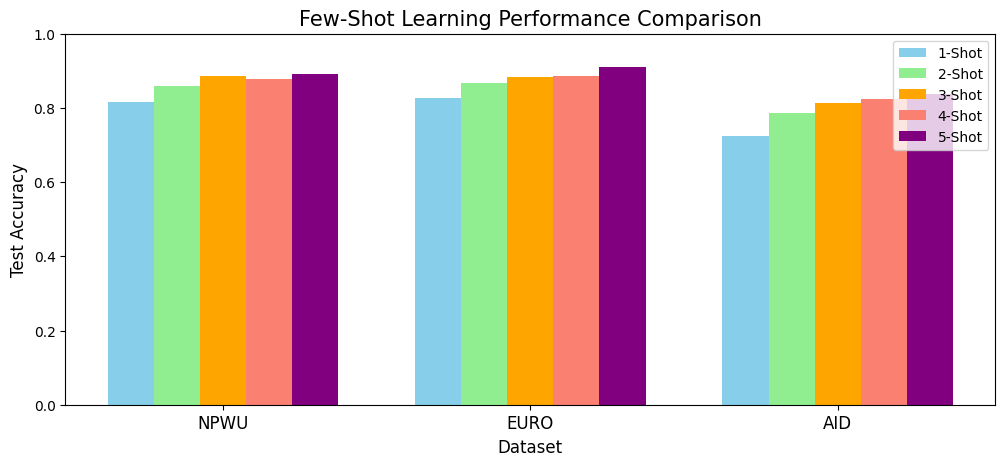

In [ ]:
# ============================================
# FINAL TESTING + FEW-SHOT GRAPH + TABLE
# ============================================

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

print("\nLoading best model from:", best_ckpt)

# Load best checkpoint --------------------------------------------------------
ckpt = torch.load(best_ckpt, map_location=device)
encoder.load_state_dict(ckpt['encoder_state'])
relation.load_state_dict(ckpt['relation_state'])

encoder.eval()
relation.eval()

# Evaluate for all SHOT values on all datasets --------------------------------
print("\nRunning Final Few-Shot Tests...\n")

final_table = {
    'Dataset': [],
    '1-Shot': [],
    '2-Shot': [],
    '3-Shot': [],
    '4-Shot': [],
    '5-Shot': []
}

for key in dataset_objs.keys():
    print(f"\n{key}:")
    final_table["Dataset"].append(key)

    for k in SHOT_LIST:
        acc = evaluate_on_dataset_fast(
            encoder, relation,
            dataset_objs[key]['test'],
            WAY, k, QUERY,
            episodes=700,      # increase for stable results
            device_eval=device
        )
        print(f"   {k}-shot: {acc*100:.2f}%")
        final_table[f"{k}-Shot"].append(acc * 100)


# Convert to DataFrame --------------------------------------------------------
df = pd.DataFrame(final_table)

# ------------------- PLOT: Bar Chart + Table -------------------

fig, ax = plt.subplots(figsize=(12, 7))

x = np.arange(len(df['Dataset']))
bar_width = 0.15

colors = ['skyblue', 'lightgreen', 'orange', 'salmon', 'purple']
shots = ['1-Shot', '2-Shot', '3-Shot', '4-Shot', '5-Shot']

# Bars
for i, shot in enumerate(shots):
    ax.bar(x + i * bar_width, df[shot] / 100, width=bar_width, label=shot, color=colors[i])

ax.set_title("Few-Shot Learning Performance Comparison", fontsize=15)
ax.set_ylabel("Accuracy", fontsize=12)
ax.set_xticks(x + bar_width * 2)
ax.set_xticklabels(df['Dataset'], fontsize=12)
ax.set_ylim(0, 1)
ax.legend()

# Create space for table
plt.subplots_adjust(bottom=0.35)

# Format table values
df_table = df.copy()
for s in shots:
    df_table[s] = df_table[s].apply(lambda x: f"{x:.2f}%")

# Add table
table = plt.table(
    cellText=df_table.values,
    colLabels=df_table.columns,
    cellLoc='center',
    loc='bottom'
)
table.scale(1, 1.7)
table.auto_set_font_size(False)
table.set_fontsize(10)

plt.show()

print(df)
